In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np # for array processing
import pandas as pd 

from scipy.stats import norm
from scipy import stats
from scipy.stats import gaussian_kde

import datetime

#import folium
from IPython.display import HTML
from IPython.display import IFrame
import base64


#from mpld3 import save_html  #Installed from conda
#from folium import IFrame

### Read in the the combined growth data that has all 2005 and 2015 data not cleaned.  

In [2]:
#dfcomb=pd.read_excel('DataFiles/NYC_Tree_05_15_combined_09Oct19.xlsx')
#dfcomb=pd.read_excel('DataFiles/PaperVersionUncleaned_05_15_combined.xlsx')
dfcomb=pd.read_csv('DataFiles/PaperVersionUncleaned_05_15_combined.csv.gz')

/Users/bmaillou/anaconda3/envs/new_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print ('original data size',dfcomb.shape)

original data size (773289, 99)


In [4]:
### remove a couple of unused solumns
dfcomb.drop(columns=['council district_15','state_15','st_assem_15', 'st_senate_15','community board_15','spc_latin_15','spc_latin_05'],inplace=True)

#### Calculate amount of growth
dfcomb.dropna(subset=['tree_dbh_05', 'tree_dbh_15'],inplace=True)
dfcomb['growth']=(dfcomb['tree_dbh_15']-dfcomb['tree_dbh_05'])
print('Data size for all trees with 2005 and 2015 data',dfcomb.shape)

Data size for all trees with 2005 and 2015 data (143192, 93)


In [5]:
#dfcomb

## 2005 to 2015 All data not Cleaned
### Compare 2005 DBH to 2015 DBH

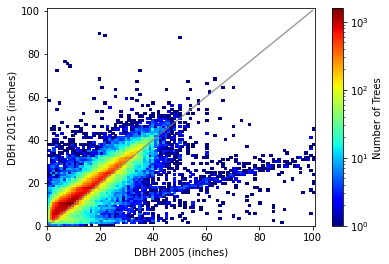

In [6]:
#https://stackoverflow.com/questions/42387471/how-to-add-a-colorbar-for-a-hist2d-plot
#https://stackoverflow.com/questions/24523670/how-do-i-use-colorbar-with-hist2d-in-matplotlib-pyplot
import copy

fig,ax=plt.subplots()

x=dfcomb['tree_dbh_05'].values.astype('float')
y=dfcomb['tree_dbh_15'].values.astype('float')

my_cmap= copy.copy(plt.cm.jet)
my_cmap.set_under('w',1)
counts, xedges, yedges, im = ax.hist2d(x, y, bins=100,range=[[0, 101], [0, 101]]
                                       , cmap=my_cmap,norm=LogNorm())

ax.plot([0,100], [0,100], c='gray',ls='-', alpha=0.75, zorder=10)

ax.set_xlabel('DBH 2005 (inches)')
ax.set_ylabel('DBH 2015 (inches)')


fig.colorbar(im, ax=ax,label='Number of Trees')

## Boxplot of 2005 DBH versus growth

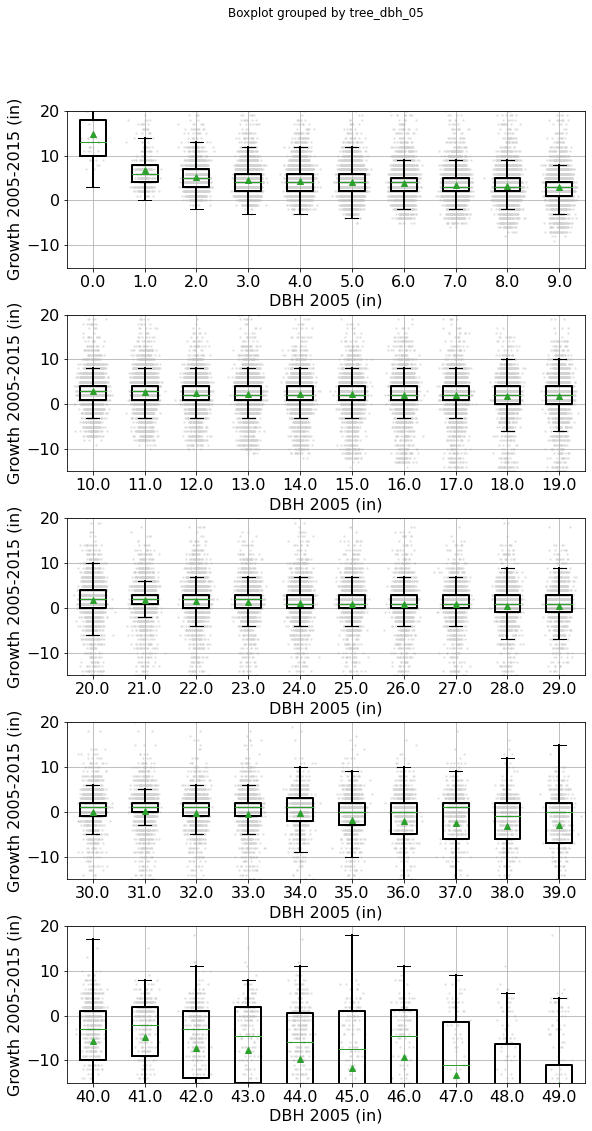

In [7]:
max_tree=40
trees_per_plot=9
num_plots=int(np.ceil(max_tree/trees_per_plot))

fig,ax=plt.subplots(num_plots)
fig.set_size_inches(9,18)
fig.subplots_adjust(hspace=0.3)

addto=0
for i in np.arange(num_plots):#num_plots):
    
    tree_low=i+i*trees_per_plot
    tree_high=i+addto+trees_per_plot
    dfcomb[(dfcomb['tree_dbh_05']>=tree_low)&(dfcomb['tree_dbh_05']<=tree_high)].\
            boxplot(column='growth',by='tree_dbh_05',ax=ax[i],fontsize=16,showmeans=True
                    ,boxprops=dict(linewidth=2.0),whiskerprops=dict(linewidth=2.0)
                   ,showfliers=False)
    ax[i].set_ylim([-15,20])
    ax[i].set_title("")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Growth 2005-2015 (in)",fontsize=16)
    ax[i].set_xlabel("DBH 2005 (in)",fontsize=16)
    
    addto+=trees_per_plot
    
    for j in np.arange(trees_per_plot+1):
        countadd=j+i*trees_per_plot
        x=np.array([])
        x = np.random.normal(j+1, 0.1, size=dfcomb[dfcomb['tree_dbh_05']==countadd]['growth'].count())
        ax[i].scatter(x,dfcomb[dfcomb['tree_dbh_05']==countadd]['growth'].dropna(),alpha=0.5,s=2,color='lightgrey')
        

        
#fig.savefig('DBHversusGrowthbyBoxplot_all_data.jpg',dpi=600)

# Clean Data
* remove >=41 2005 DBH
* remove <=0 2005 DBH
* remove less than <-5 growth
* remove top and bottom 5% by 1 inch increments


In [8]:
#dftemp=dfcomb
print('total_trees',dfcomb.growth.count())

dfcomb=dfcomb[dfcomb['tree_dbh_05']<41]
print('After removing>41',dfcomb.growth.count())

dfcomb=dfcomb[dfcomb['tree_dbh_05']>0]
print('After removing 0 DBH in 2005',dfcomb.growth.count())

dfcomb=dfcomb[dfcomb['growth']>=-5]
print('After removing growth less than -5 inches',dfcomb.growth.count())


for i in np.arange(41):
    #print(i,dftemp[dftemp['tree_dbh_05']==i]['growth'].quantile(.95))
    cutH=dfcomb[dfcomb['tree_dbh_05']==i]['growth'].quantile(.95)
    cutL=dfcomb[dfcomb['tree_dbh_05']==i]['growth'].quantile(.05)
    
    dfcomb.drop(dfcomb[(dfcomb['tree_dbh_05']==i)&(dfcomb['growth']>cutH)].index,inplace=True)
    dfcomb.drop(dfcomb[(dfcomb['tree_dbh_05']==i)&(dfcomb['growth']<cutL)].index,inplace=True)

print('After removing growth bottom and top 5% by DBH inch',dfcomb.growth.count())
    

### calculate growth rate
dfcomb['growth_rate']=dfcomb['growth']/10

############ Print to Excel when needed
print('printing to excel')
dfcomb.to_excel('DataFiles/Cleaned_NYC_Growth.xlsx')
print('done trimming data.  The shape is',dfcomb.shape)


total_trees 143192
After removing>41 141926
After removing 0 DBH in 2005 141874
After removing growth less than -5 inches 137039
After removing growth bottom and top 5% by DBH inch 126362
printing to excel
done trimming data.  The shape is (126362, 94)


## Examine Cleaned data
## Boxplot of 2005 DBH versus growth

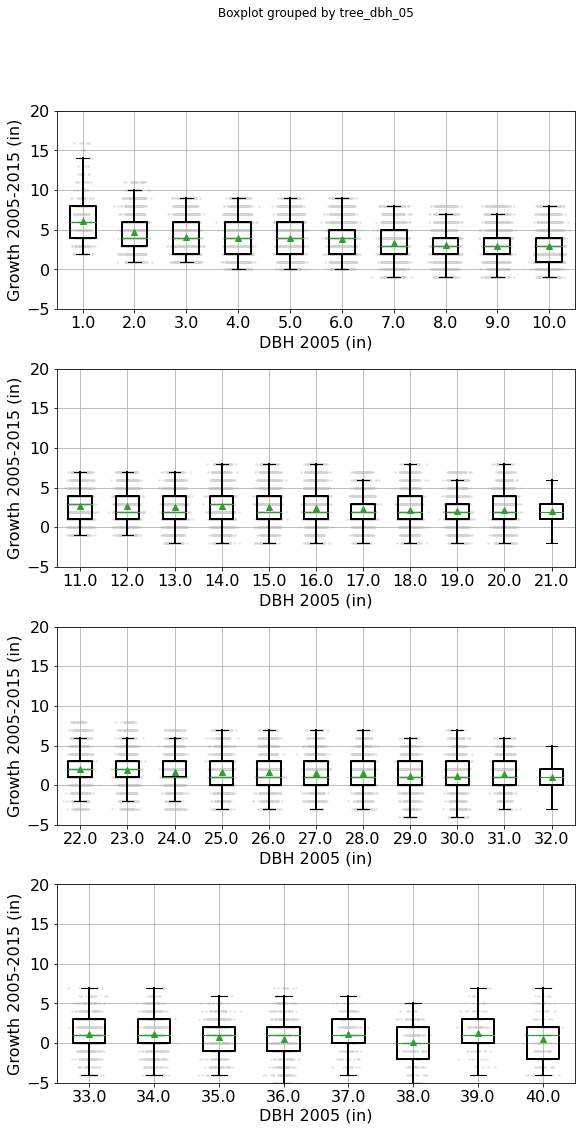

In [9]:
max_tree=40
trees_per_plot=10
num_plots=int(np.ceil(max_tree/trees_per_plot))

fig,ax=plt.subplots(num_plots)
fig.set_size_inches(9,18)
fig.subplots_adjust(hspace=0.3)

addto=0
for i in np.arange(num_plots):#num_plots):
    if i==0:
        tree_low=1
        tree_high=10
    else:
        tree_low=i+i*trees_per_plot
        tree_high=i+addto+trees_per_plot
    dfcomb[(dfcomb['tree_dbh_05']>=tree_low)&(dfcomb['tree_dbh_05']<=tree_high)].\
            boxplot(column='growth',by='tree_dbh_05',ax=ax[i],fontsize=16,showmeans=True
                    ,boxprops=dict(linewidth=2.0),whiskerprops=dict(linewidth=2.0)
                   ,showfliers=False)
    ax[i].set_ylim([-5,20])
    ax[i].set_title("")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Growth 2005-2015 (in)",fontsize=16)
    ax[i].set_xlabel("DBH 2005 (in)",fontsize=16)
    addto+=len(ax[0].get_xticklabels())

    #### Add the scatter points
    for j in np.arange(len(ax[0].get_xticklabels())):
        countadd=j+i*trees_per_plot
        x=np.array([])
        x = np.random.normal(j+1, 0.1, size=dfcomb[dfcomb['tree_dbh_05']==tree_low]['growth'].count())
        ax[i].scatter(x,dfcomb[dfcomb['tree_dbh_05']==tree_low]['growth'].dropna(),alpha=0.5,s=2,color='lightgrey')
        tree_low+=1

        
#fig.savefig('DBHversusGrowthTrimbyBoxplot.jpg',dpi=600)

### Plots of cleaned 2005 versus 2015 DBH

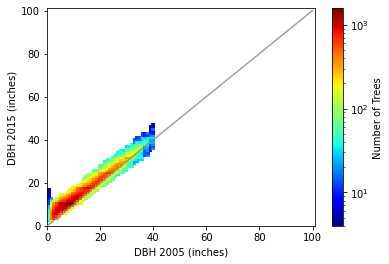

In [10]:
#https://stackoverflow.com/questions/42387471/how-to-add-a-colorbar-for-a-hist2d-plot
#https://stackoverflow.com/questions/24523670/how-do-i-use-colorbar-with-hist2d-in-matplotlib-pyplot
import copy

fig,ax=plt.subplots()

x=dfcomb['tree_dbh_05'].values.astype('float')
y=dfcomb['tree_dbh_15'].values.astype('float')

my_cmap= copy.copy(plt.cm.jet)
my_cmap.set_under('w',1)
counts, xedges, yedges, im = ax.hist2d(x, y, bins=100,range=[[0, 101], [0, 101]]
                                       , cmap=my_cmap,norm=LogNorm())

ax.plot([0,100], [0,100], c='gray',ls='-', alpha=0.75, zorder=10)

ax.set_xlabel('DBH 2005 (inches)')
ax.set_ylabel('DBH 2015 (inches)')


fig.colorbar(im, ax=ax,label='Number of Trees')

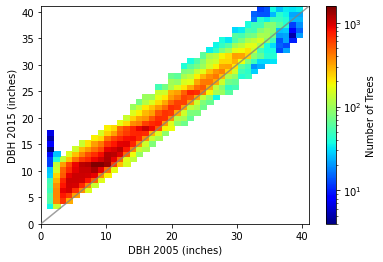

In [11]:
#https://stackoverflow.com/questions/42387471/how-to-add-a-colorbar-for-a-hist2d-plot
#https://stackoverflow.com/questions/24523670/how-do-i-use-colorbar-with-hist2d-in-matplotlib-pyplot
import copy

fig,ax=plt.subplots()

x=dfcomb['tree_dbh_05'].values.astype('float')
y=dfcomb['tree_dbh_15'].values.astype('float')

my_cmap= copy.copy(plt.cm.jet)
my_cmap.set_under('w',1)
counts, xedges, yedges, im = ax.hist2d(x, y, bins=42,range=[[0, 41], [0, 41]]
                                       , cmap=my_cmap,norm=LogNorm())

ax.plot([0,41], [0,41], c='gray',ls='-', alpha=0.75, zorder=10)

ax.set_xlabel('DBH 2005 (inches)')
ax.set_ylabel('DBH 2015 (inches)')


fig.colorbar(im, ax=ax,label='Number of Trees')

## Basic Statistics Paragraph 1 Results. 
pandas describe

In [12]:
#dfcomb['growth_rate']=dfcomb['growth']/10
print(dfcomb['growth_rate'].describe())

count    126362.000000
mean          0.275303
std           0.233739
min          -0.500000
25%           0.100000
50%           0.300000
75%           0.400000
max           1.600000
Name: growth_rate, dtype: float64


Percentages in Paragraph 1

In [13]:
temp=(dfcomb['growth_rate']>=0).value_counts()
print('Growth rates >=0 {}\nGrowth rates <0 {}'.format(temp[0],temp[1]))

temp=(dfcomb['growth_rate']>=0).value_counts()/(dfcomb['growth_rate']>0).count()
print('\n% Growth rates >=0 {}\n% Growth rates <0 {}'.format(temp[0]*100,temp[1]*100))

temp=np.logical_and(dfcomb['growth_rate']>=0,dfcomb['growth_rate']<=1).value_counts()
print('\nGrowth rates 0-1 inclusive {}'.format(temp[1]))


Growth rates >=0 7706
Growth rates <0 118656

% Growth rates >=0 6.09835235276428
% Growth rates <0 93.90164764723572

Growth rates 0-1 inclusive 118585


Species in Paragraph 1

In [14]:
print('total species',dfcomb['spc_common'].value_counts().count())
print('species >1000 trees',(dfcomb['spc_common'].value_counts()>1000).value_counts()[1])
print('species 10-100 trees',(np.logical_and(dfcomb['spc_common'].value_counts()<=1000
                                   ,dfcomb['spc_common'].value_counts()>100)).value_counts()[1])


total species 59
species >1000 trees 14
species 10-100 trees 10


## TABLE 2

In [15]:
#dfT2=dfcomb.groupby('spc_common')['growth_rate'].describe()
dfT2=dfcomb.groupby('spc_common').agg({'growth_rate': ['count', 'mean','std']
                                       , 'tree_dbh_05': ['mean','median']})

In [16]:
dfT2.sort_values(by=('growth_rate', 'count'),ascending=False)

growth_rate                     tree_dbh_05       
                          count      mean       std        mean median
spc_common                                                            
london planetree          32058  0.163288  0.214572   22.476418   22.0
honeylocust               15974  0.356229  0.215312    9.095405    9.0
callery pear              15903  0.334251  0.215544    6.615544    6.0
norway maple              13149  0.173587  0.187958   13.392121   13.0
pin oak                   11563  0.352002  0.244596   16.801436   17.0
littleleaf linden          6343  0.317768  0.205402    9.696358    9.0
ginkgo                     5518  0.256832  0.210757    9.011417    8.0
green ash                  4893  0.365870  0.205146   10.878602   10.0
red maple                  4116  0.272643  0.218445   10.052478    8.0
silver maple               3948  0.265198  0.242683   20.408561   20.0
japanese zelkova           3643  0.424815  0.214825    8.175679    8.0
sweetgum                   2620  0.308015  0.226273   11.004198   10.0
silver linden              1149  0.510270  0.213480    6.664926    6.0
northern red oak           1026  0.374756  0.245498   12.693957   10.0
american linden             868  0.399078  0.225889   10.832949    9.0
american elm                570  0.315789  0.230983   15.215789   13.0
willow oak                  447  0.367785  0.243278   14.154362   13.0
sycamore maple              338  0.136982  0.181551   11.411243   12.0
amur maple                  312  0.352564  0.171038    5.217949    5.0
hedge maple                 288  0.335417  0.176085    4.645833    4.0
japanese maple              205  0.233659  0.198002    6.224390    5.0
sugar maple                 188  0.224468  0.182781   10.090426    9.0
japanese tree lilac         159  0.227673  0.116332    3.050314    3.0
swamp white oak             157  0.495541  0.214040    4.585987    4.0
sawtooth oak                 99  0.414141  0.215241    5.434343    5.0
black locust                 93  0.323656  0.221358   14.827957   14.0
chinese elm                  82  0.363415  0.215746    7.817073    6.0
flowering dogwood            80  0.128750  0.171511    6.650000    6.0
english oak                  71  0.456338  0.204752    6.549296    5.0
mulberry                     70  0.310000  0.267110   15.800000   15.0
white oak                    65  0.375385  0.228467   14.030769    7.0
catalpa                      64  0.201562  0.202753   18.312500   18.0
dawn redwood                 59  0.605085  0.232989    4.881356    3.0
kentucky coffeetree          49  0.416327  0.171205    4.204082    4.0
eastern redbud               39  0.423077  0.233353    3.538462    3.0
katsura tree                 38  0.400000  0.204014    3.815789    3.0
european hornbeam            25  0.364000  0.160416    4.560000    4.0
tree of heaven               18  0.461111  0.285201   14.333333   14.0
white ash                    15  0.426667  0.138701   10.533333    6.0
siberian elm                  9  0.233333  0.250000   22.555556   26.0
eastern redcedar              8  0.187500  0.210017    8.250000    5.5
norway spruce                 7  0.185714  0.146385   12.428571   10.0
black cherry                  5  0.060000  0.054772   24.000000   23.0
sassafras                     5  0.040000  0.054772   14.000000   15.0
eastern cottonwood            3  0.466667  0.288675   19.333333   21.0
american beech                3  0.333333  0.351188   18.333333   15.0
river birch                   3  0.600000  0.173205    5.333333    6.0
shingle oak                   2  0.700000  0.282843    2.000000    2.0
kousa dogwood                 2  0.150000  0.070711    3.500000    3.5
boxelder                      2  0.300000  0.141421   18.500000   18.5
black walnut                  2  0.300000  0.000000    7.500000    7.5
american hornbeam             2  0.350000  0.070711    3.000000    3.0
scarlet oak                   1  0.900000       NaN    2.000000    2.0
bur oak                       1  0.100000   